# Maps of Amsterdam and dummy datasets

In [1]:
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
import seaborn as sns
sns.set_theme(style="darkgrid")

p_resono = '/home/serzhilin/Documents/Postdoc/datasets/dummy/resono/'

/home/serzhilin/jupyter/jupyterenv/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


## Functions

In [2]:
#snippet to scale up canvas
def scale_plot_size(factor=2):
    import matplotlib as mpl
    default_dpi = mpl.rcParamsDefault['figure.dpi']
    mpl.rcParams['figure.dpi'] = default_dpi*factor
scale_plot_size()

In [3]:
# transforms GeoDF into folium GeoJson
def folium_geojson(poly_gdf, layer_group='polygones', color='orange', simplify=False):
    geos = gpd.GeoSeries(poly_gdf['geometry'])
    if simplify:
        geos = geos.simplify(tolerance=0.001)
    return folium.GeoJson(data=geos.to_json(),
                           style_function=lambda x: {'fillColor': color}, 
                           name=layer_group, 
                           control=False)

In [25]:
def fts(fl):
    return str(int(fl))

## Read resono csv wkt polygones -> geoDataFrame

In [5]:
#read resono geometry csv into pandas DataFrame
p_resono_geo = 'resono_geometry.csv'
resono_geo = pd.read_csv(p_resono + p_resono_geo, sep=';')
#transform DataFrame into GeoDataFrame
#resono_gdf
resono_geo['geometry'] = gpd.GeoSeries.from_wkt(resono_geo['geometry'])

resono_gdf = gpd.GeoDataFrame(resono_geo, geometry='geometry')

<AxesSubplot:>

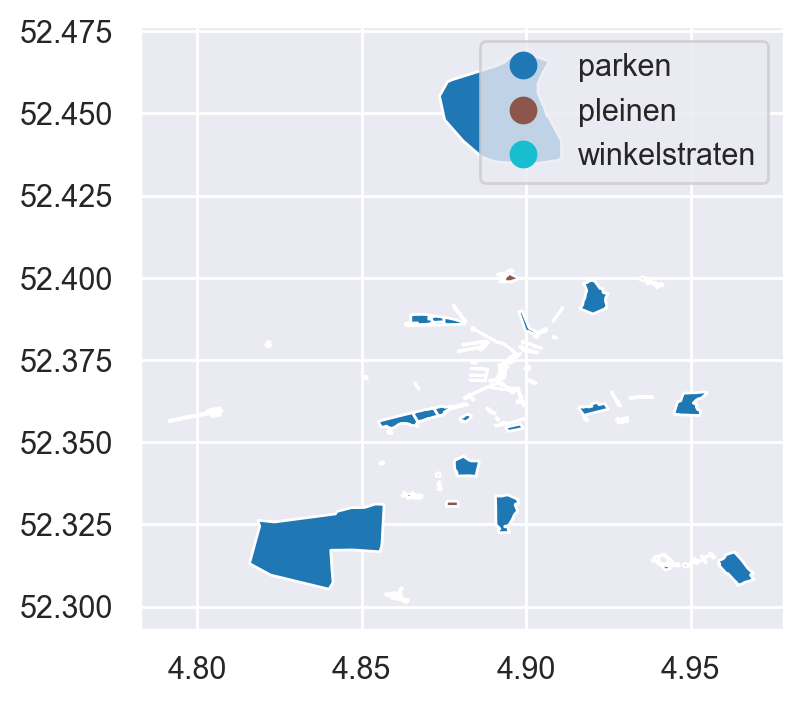

In [6]:
#plot polygones to check that everything is ok
resono_gdf.plot(legend = True, column = 'type')

In [7]:

# set CRS WSG 84
resono_gdf = resono_gdf.set_crs('epsg:4326')
#gdf = gdf.set_crs('epsg:4258')
resono_gdf.crs
'''
# CRS ETRS89
resono_gdf = resono_gdf.to_crs(epsg=4258)
resono_gdf.crs
resono_gdf.plot(legend = True, column = 'type', figsize = (20, 10))
'''

"\n# CRS ETRS89\nresono_gdf = resono_gdf.to_crs(epsg=4258)\nresono_gdf.crs\nresono_gdf.plot(legend = True, column = 'type', figsize = (20, 10))\n"

## Map with Resono polygones

In [9]:

m = folium.Map(location=[52.3719978, 4.9013211], tiles = 'Stamen Toner', zoom_start = 13)
#folium.GeoJson(gdf, name="resono").add_to(m)

for _, r in resono_gdf.iterrows():
    #todo: change to lambda function
    col = 'blue'
    if r['type'] == 'pleinen':
        col = 'orange'
    elif r['type'] == 'parken':
        col = 'green'
    geo_j = folium_geojson(poly_gdf=r, color=col)
    folium.Popup(r['location']).add_to(geo_j)
    geo_j.add_to(m)
    
folium.LayerControl().add_to(m)

m

What I wanna do with the map:
* Function sort_*poly_by_type* that sort a *gdf* into dict *lst_poly_by_type* of GeoDS based on their type
* Function *add_poly_layer* with color and name of layer (now it adds things one by one)
Eventually we get a map with layers by type of poly and colors and additional data in popups

Then if we merge datasets I can write data into popups of polygones

Next, I can upload all this shit on my server)))

## Map with Resono polygones and visitors info

In [42]:
#get csv Resono visitors by hour
p_resono_hourly = 'resono_hourly_visits_130322_190322.csv'
resono_hourly = pd.read_csv(p_resono + p_resono_hourly)

#select only data of one day
select_date = '2022-03-19'
resono_hourly_day = resono_hourly[resono_hourly["Date"] == select_date]

#group by location
gr_by_loc = resono_hourly_day.groupby('Location')

In [40]:
#create a new map
m = folium.Map(location=[52.3719978, 4.9013211], tiles = 'Stamen Toner', zoom_start = 13)

# iterate Resono polygones
for _, r in resono_gdf.iterrows():
    #todo: change to lambda function
    col = 'blue'
    if r['type'] == 'pleinen':
        col = 'orange'
    elif r['type'] == 'parken':
        col = 'green'
    geo_j = folium_geojson(poly_gdf=r, color=col)
    
    #get data of current location
    l = gr_by_loc.get_group(r['location'])
    l = l.sum(numeric_only=True)
    # make html 
    popup_html = '''\<p>
     <h3>{Location}</h3></br>
    <strong>Visits</strong>: {Visits}</br>
    <strong>Unique</strong>: {Unique}</br>
    <strong>Recurring</strong>: {Recurring}</br>
    <hr>
    <center><strong>Normalized</strong></center>
    <strong>Visits</strong>: {Visits}</br>
    <strong>Unique</strong>: {Unique}</br>
    <strong>Recurring</strong>: {Recurring}</br>
    </p>\
    '''.format(Location=r['location'],
            Visits=fts(l.Visits), 
            Unique=fts(l.Unique),
            Recurring=fts(l.Recurring),
            Visits_norm=fts(l.Visits_norm), 
            Unique_norm=fts(l.Unique_norm),
            Recurring_norm=fts(l.Recurring_norm))
    
    # create folium Popup and adds it to polygone
    folium.Popup(popup_html, max_width=500).add_to(geo_j)
    geo_j.add_to(m)
    
folium.LayerControl().add_to(m)

m


## Amsterdam PC4

In [31]:
p_pc4 = '/home/serzhilin/Documents/Postdoc/datasets/PC4.json'
pc4_df = gpd.read_file(p_pc4)
pc4_df
#url_pc4 = 'https://maps.amsterdam.nl/open_geodata/geojson_lnglat.php?KAARTLAAG=PC4_BUURTEN&THEMA=postcode'
#response = requests.get(url_pc4)
#data = response.json()

,Postcode4,Opp_m2,geometry
0,1037,1467857,"POLYGON ((4.85609 52.41666, 4.85948 52.41976, ..."
1,1041,3286912,"POLYGON ((4.82773 52.42078, 4.82860 52.42067, ..."
2,1073,588271,"POLYGON ((4.89287 52.35824, 4.89804 52.35793, ..."
3,1074,431143,"POLYGON ((4.89925 52.35809, 4.90168 52.35859, ..."
4,1072,595621,"POLYGON ((4.88739 52.36022, 4.88766 52.36008, ..."
...,...,...,...
76,1022,1388205,"MULTIPOLYGON (((4.91823 52.38974, 4.91880 52.3..."
77,1036,272259,"POLYGON ((4.90187 52.41190, 4.90427 52.41016, ..."
78,1033,3826615,"POLYGON ((4.86363 52.41390, 4.86777 52.41826, ..."
79,1042,3671105,"POLYGON ((4.80995 52.42302, 4.82432 52.42116, ..."


In [65]:
p_ggd = '/home/serzhilin/Documents/Postdoc/datasets/dummy/ggd/dummydata_coronit_patient_for_sharing.csv'
ggd = pd.read_csv(p_ggd)

#select only data of one day
select_week = 202213
ggd_week = ggd[ggd["YearWkNr_appointment_made"] == select_week]

#group by location
ggd_by_pc4 = ggd_week.groupby('PC4')
ggd_by_pc4.ngroups
test = ggd_by_pc4.get_group(1055)
test

,YearWkNr_appointment_made,PC4,age_groups_2021,gender,unique_patient_count_shuffle_replace
233884,202213,1055,18-25,MAN,8
233885,202213,1055,18-25,VROUW,5
233886,202213,1055,26-30,MAN,1
233887,202213,1055,26-30,VROUW,4
233888,202213,1055,31-35,MAN,1
233889,202213,1055,31-35,VROUW,120
233890,202213,1055,36-40,MAN,5
233891,202213,1055,36-40,VROUW,25
233892,202213,1055,41-45,MAN,2
233893,202213,1055,41-45,VROUW,12


In [76]:
m = folium.Map(location=[52.3719978, 4.9013211], tiles = 'Stamen Toner', zoom_start = 13)

for _, r in pc4_df.iterrows():
    geo_j = folium_geojson(poly_gdf=r)
    pc4_int = int(r['Postcode4'])
    html = '<p><strong>Postcode: '+ r['Postcode4'] + '</strong></br>'
    try:
        pc4 = ggd_by_pc4.get_group(pc4_int)
        inf = str(pc4.sum(numeric_only=True).unique_patient_count_shuffle_replace)
        html += 'Infections: ' + inf + '</p>'
    except:
        html += 'No data :(</p>'
    folium.Popup(html, show=True, max_width=300).add_to(geo_j)
    geo_j.add_to(m)
    
folium.LayerControl().add_to(m)

m

## Amsterdam PC4 + GGD data

In [ ]:
p_ggd = '/home/serzhilin/Documents/Postdoc/datasets/dummy/ggd/dummydata_coronit_patient_for_sharing.csv'
ggd = pd.read_csv(p_ggd)

## References

Seems I have to swap lat-lon in geodataframe - https://gis.stackexchange.com/questions/378431/mapping-multiple-polygons-on-folium
Folium documentation - https://python-visualization.github.io/folium
GoePandas -> Folium - https://geopandas.org/en/stable/gallery/polygon_plotting_with_folium.html